# linearAlgebra

In [2]:
# Load libraries
import torch
import torch.nn as nn
#from res.plot_lib import set_default, show_scatterplot, plot_bases
from matplotlib.pyplot import plot, title, axis

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Remove xticks for vectors
    ax2.set_xticks(tuple())
    ax3.set_xticks(tuple())
    
    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)


colors = dict(
    aqua='#8dd3c7',
    yellow='#ffffb3',
    lavender='#bebada',
    red='#fb8072',
    blue='#80b1d3',
    orange='#fdb462',
    green='#b3de69',
    pink='#fccde5',
    grey='#d9d9d9',
    violet='#bc80bd',
    unk1='#ccebc5',
    unk2='#ffed6f',
)


def _cstr(s, color='black'):
    if s == ' ':
        return f'<text style=color:#000;padding-left:10px;background-color:{color}> </text>'
    else:
        return f'<text style=color:#000;background-color:{color}>{s} </text>'

# print html
def _print_color(t):
    display(HTML(''.join([_cstr(ti, color=ci) for ti, ci in t])))

# get appropriate color for value
def _get_clr(value):
    colors = ('#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e')
    value = int((value * 100) / 5)
    if value == len(colors): value -= 1  # fixing bugs...
    return colors[value]

def _visualise_values(output_values, result_list):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], _get_clr(output_values[i]))
        text_colours.append(text)
    _print_color(text_colours)

def print_colourbar():
    color_range = torch.linspace(-2.5, 2.5, 20)
    to_print = [(f'{x:.2f}', _get_clr((x+2.5)/5)) for x in color_range]
    _print_color(to_print)


# Let's only focus on the last time step for now
# First, the cell state (Long term memory)
def plot_state(data, state, b, decoder):
    actual_data = decoder(data[b, :, :].numpy())
    seq_len = len(actual_data)
    seq_len_w_pad = len(state)
    for s in range(state.size(2)):
        states = torch.sigmoid(state[:, b, s])
        _visualise_values(states[seq_len_w_pad - seq_len:], list(actual_data))

In [4]:
# Set style (needs to be in a new cell)
set_default()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

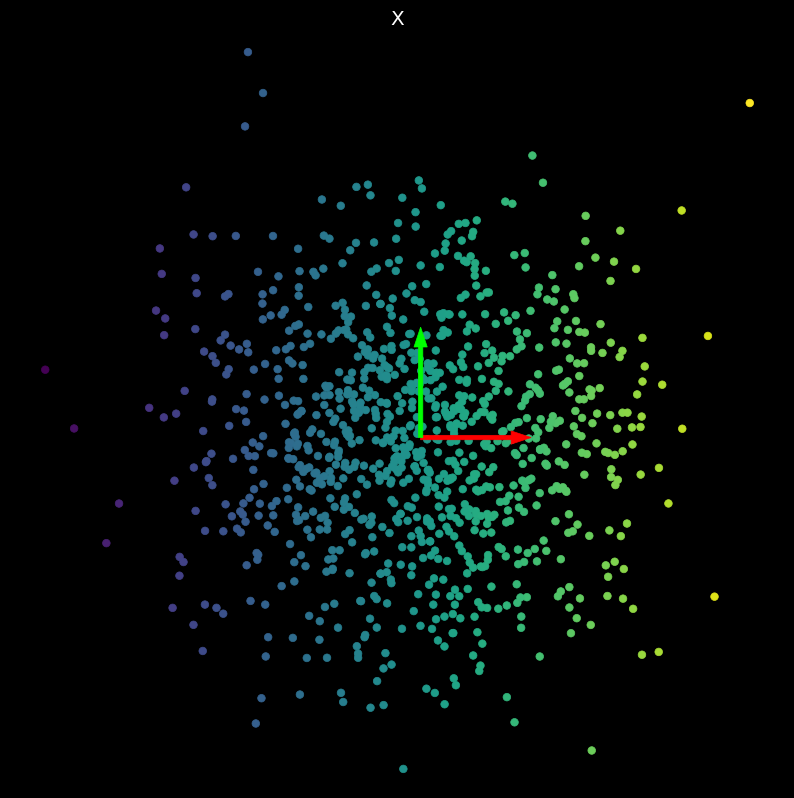

In [7]:
# generate some points in 2-D space
n_points = 1000
X = torch.randn(n_points, 2).to(device)
colors = X[:, 0]

show_scatterplot(X, colors, title='X')
OI = torch.cat((torch.zeros(2, 2), torch.eye(2))).to(device)
plot_bases(OI)

Visualizing Linear Transformations
Generate a random matrix $W$
$
\begin{equation}
    W = U
  \left[ {\begin{array}{cc}
   s_1 &amp; 0 \\
   0 &amp; s_2 \\
  \end{array} } \right]
  V^\top
\end{equation}
$

Compute $y = Wx$
Larger singular values stretch the points
Smaller singular values push them together
$U, V$ rotate/reflect

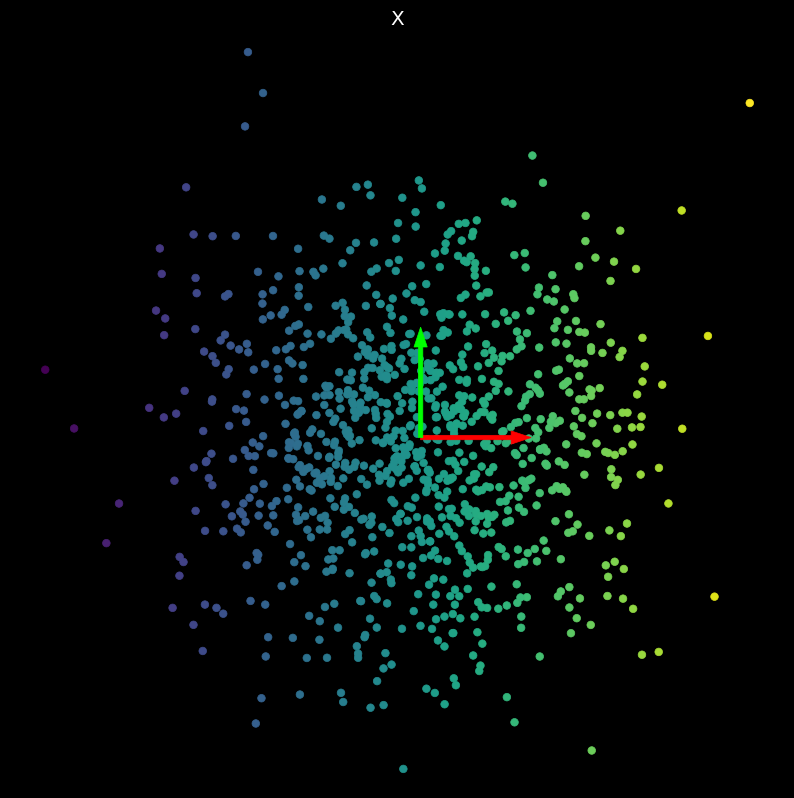

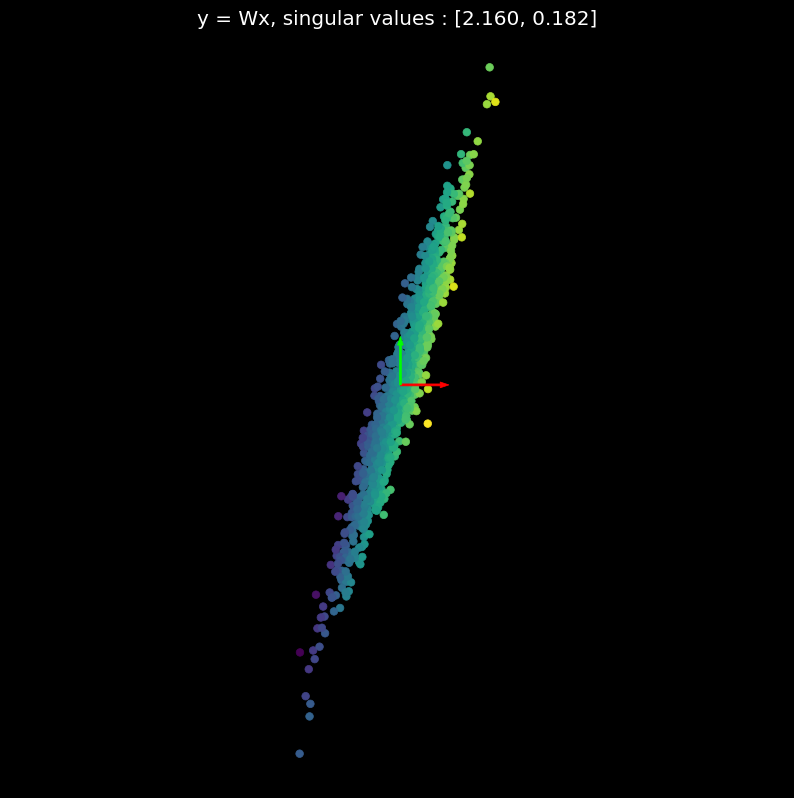

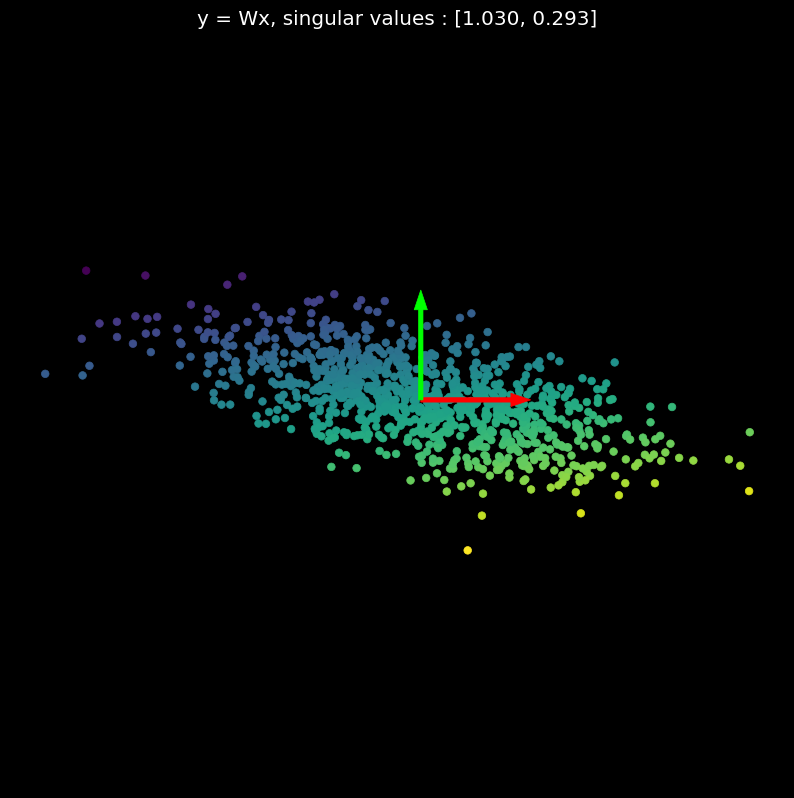

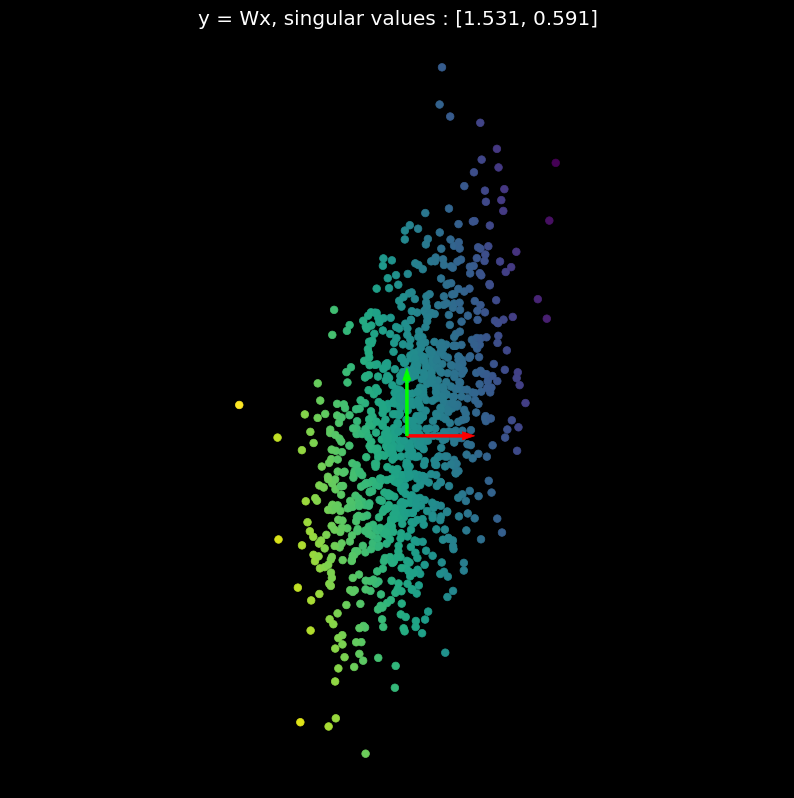

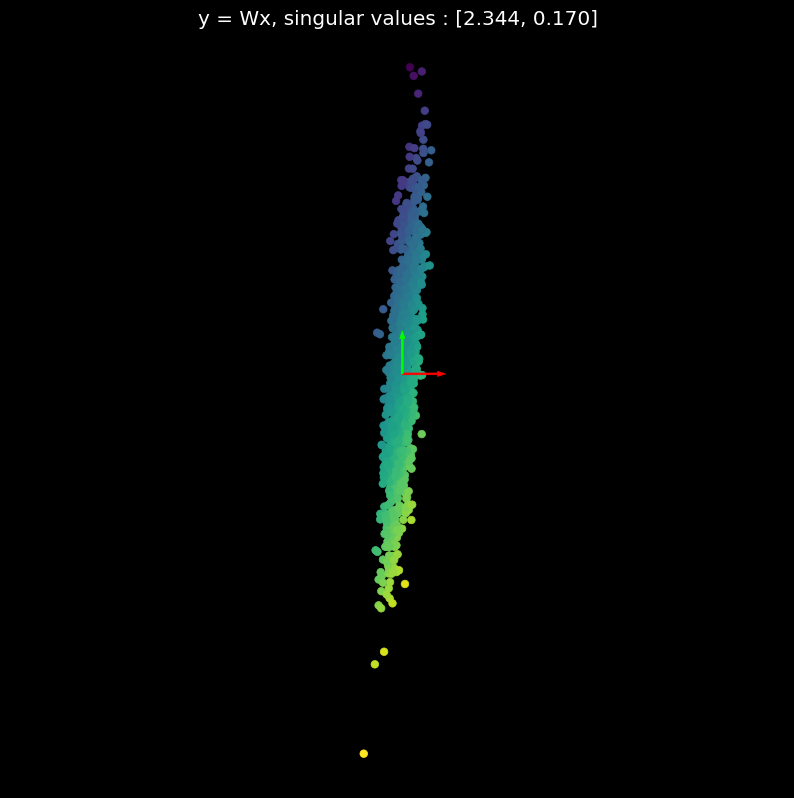

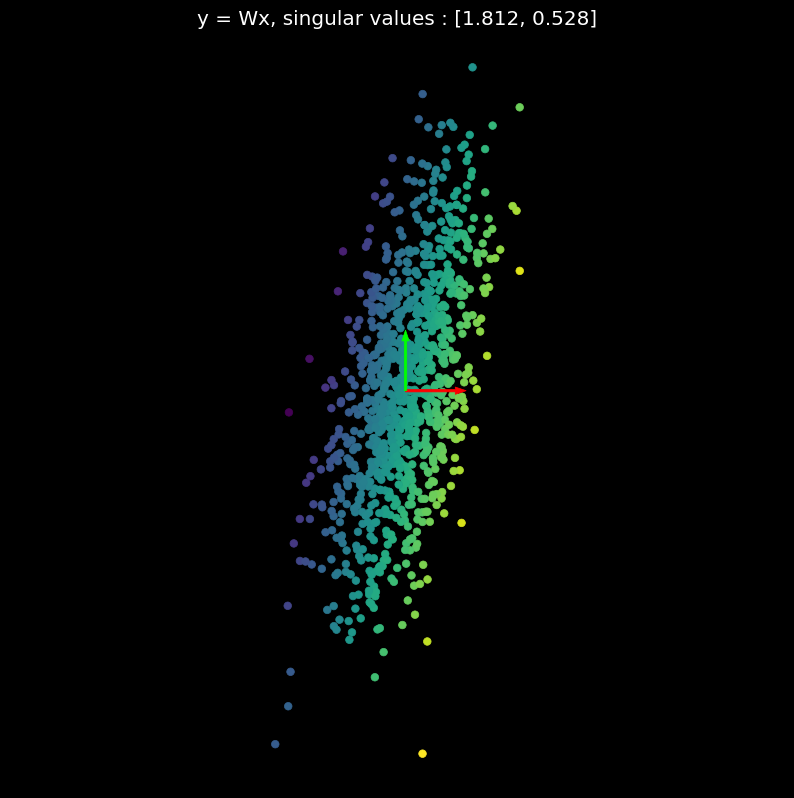

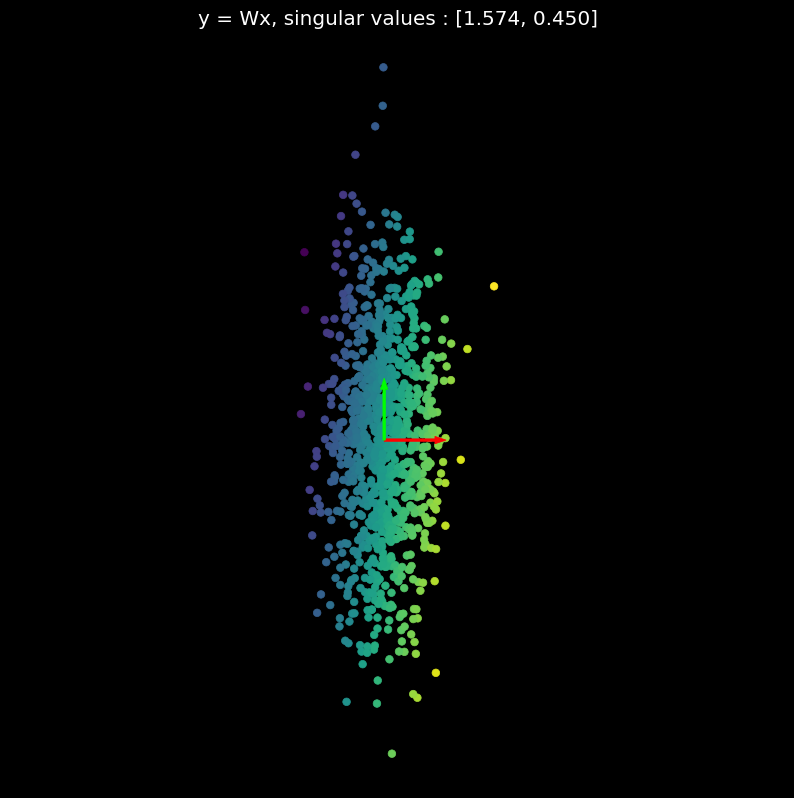

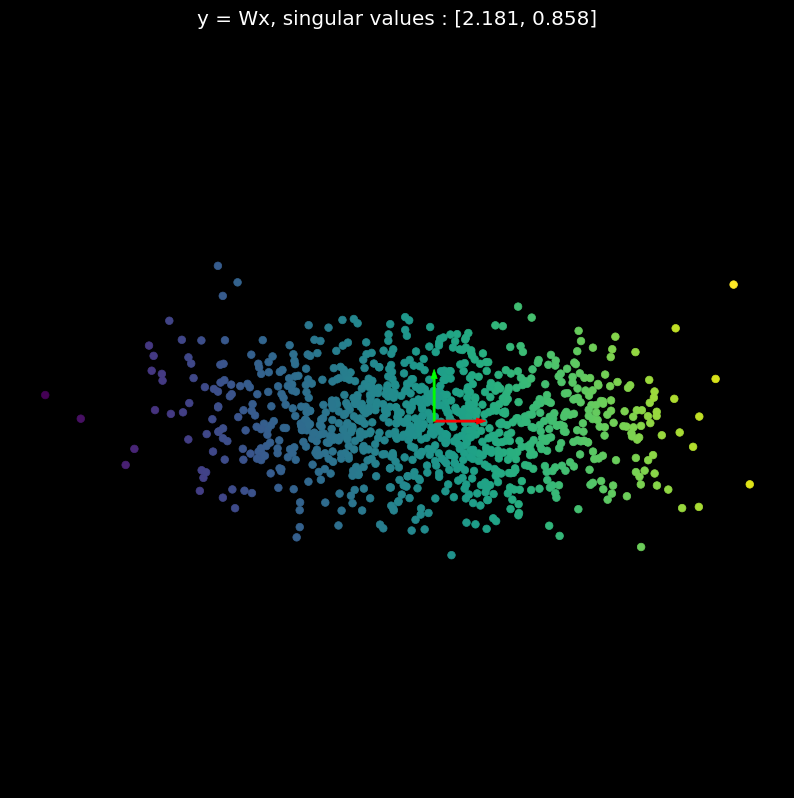

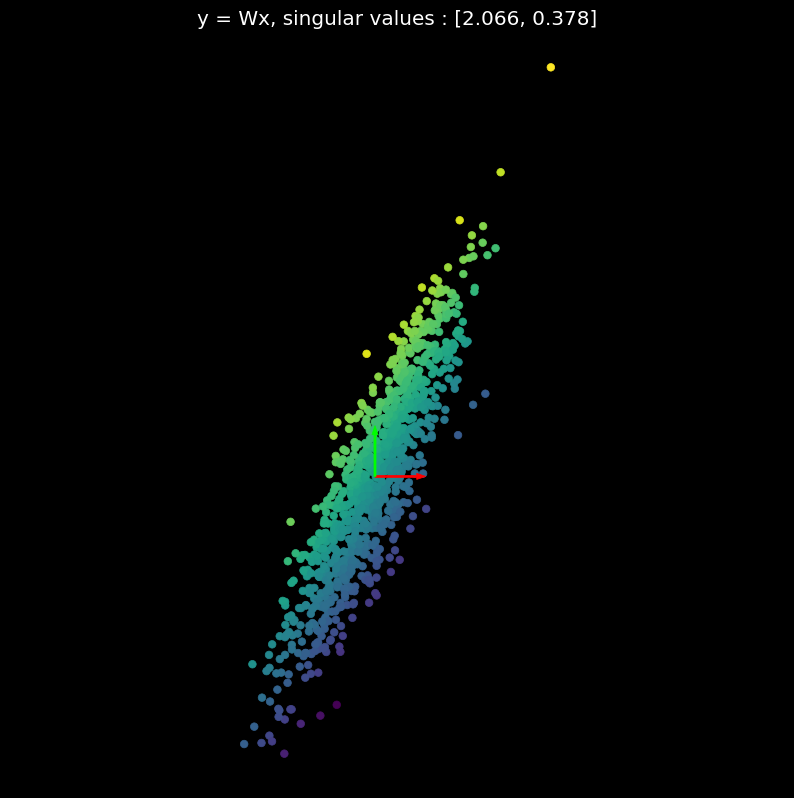

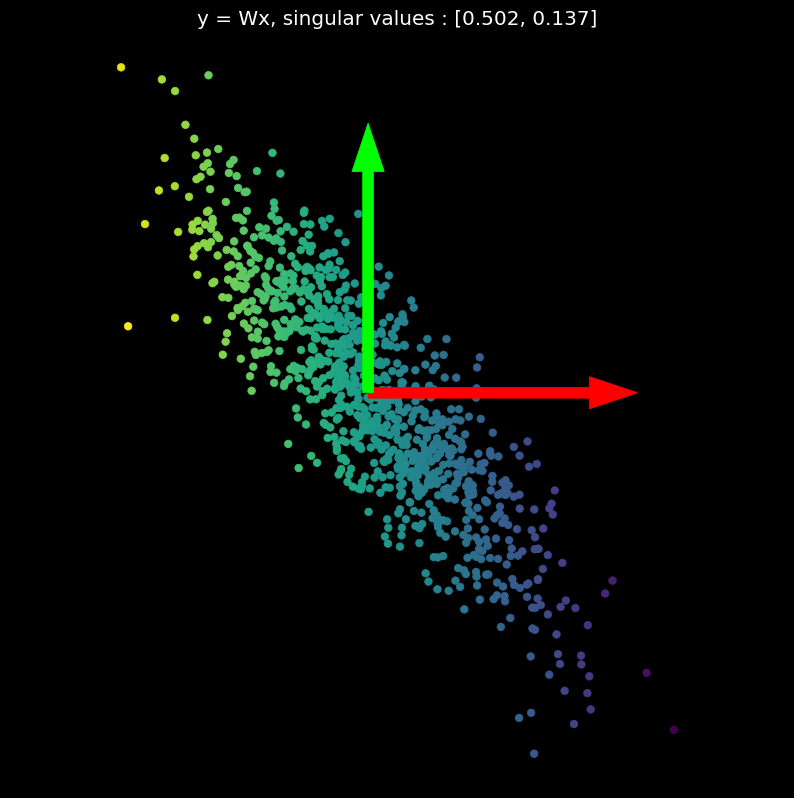

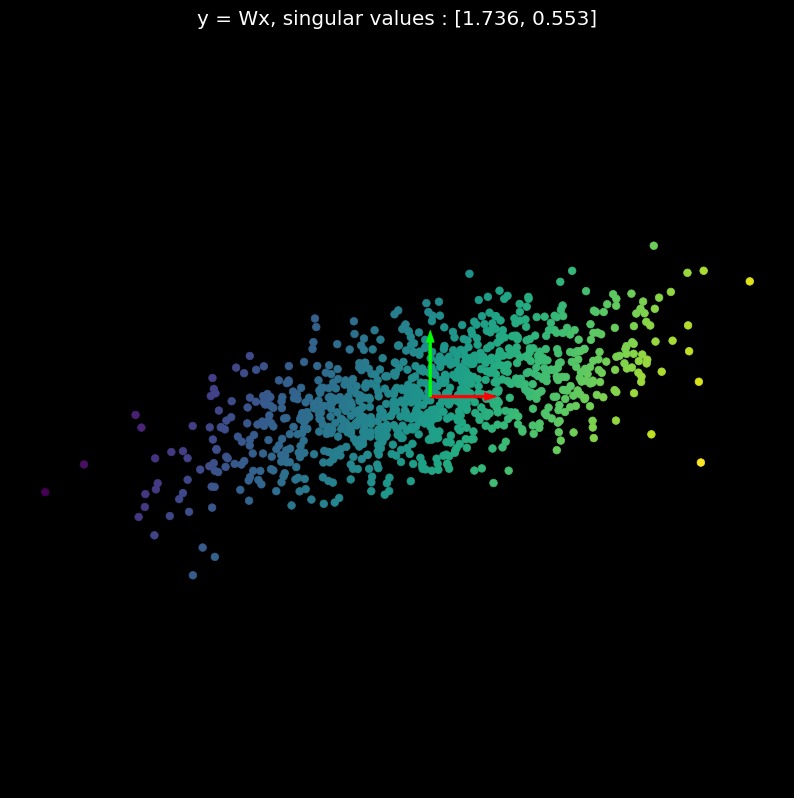

In [10]:
show_scatterplot(X, colors, title='X')
plot_bases(OI)

for i in range(10):
    # create a random matrix
    W = torch.randn(2, 2).to(device)
    # transform points
    Y = X @ W.t()
    # compute singular values
    U, S, V = torch.svd(W)
    # plot transformed points
    show_scatterplot(Y, colors, title='y = Wx, singular values : [{:.3f}, {:.3f}]'.format(S[0], S[1]))
    # transform the basis
    new_OI = OI @ W.t()
    # plot old and new basis
    plot_bases(OI)
    #plot_bases(new_OI)

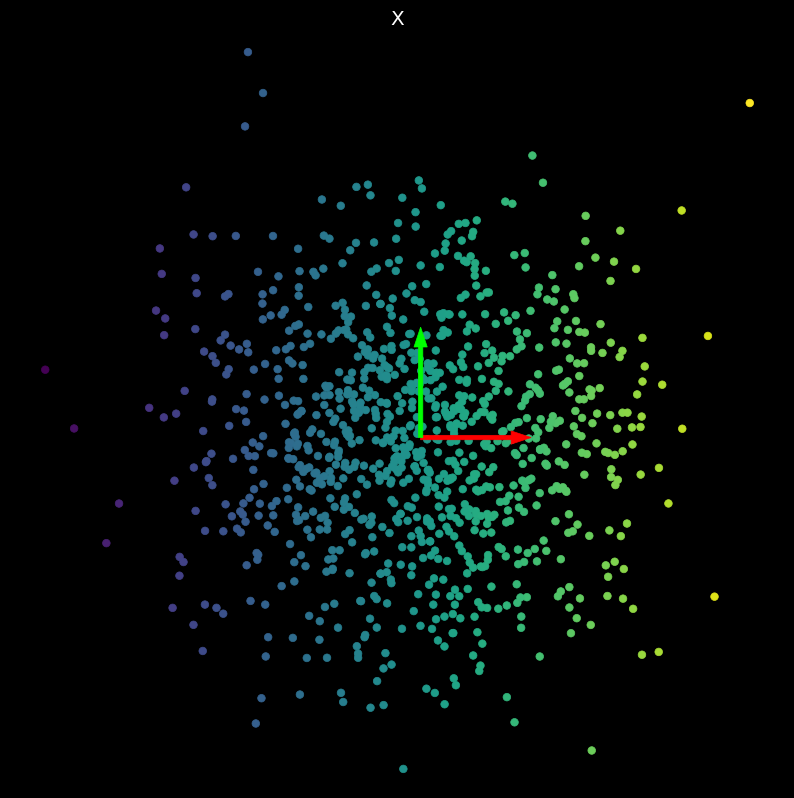

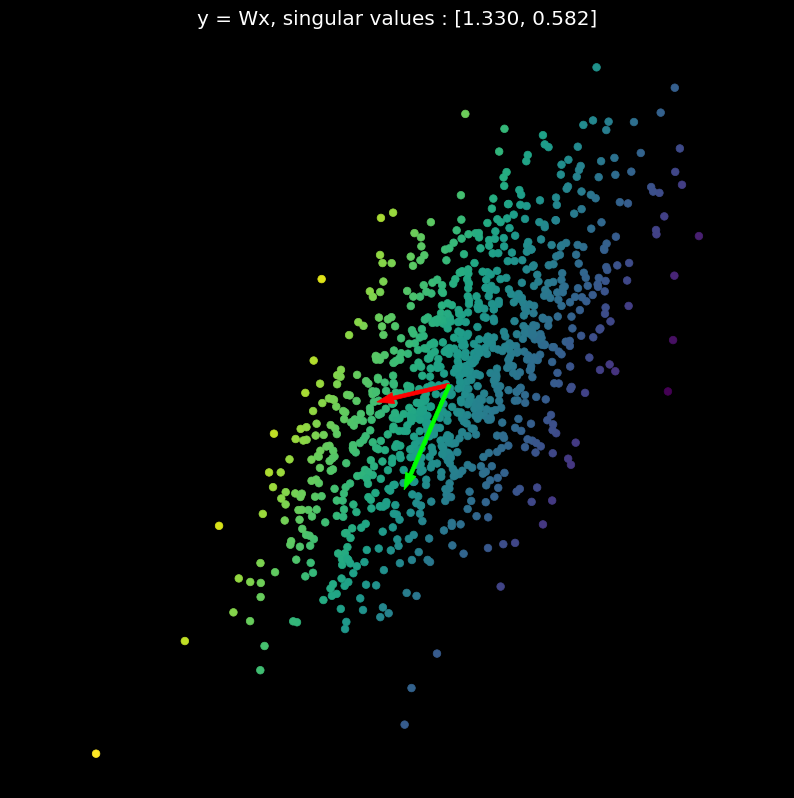

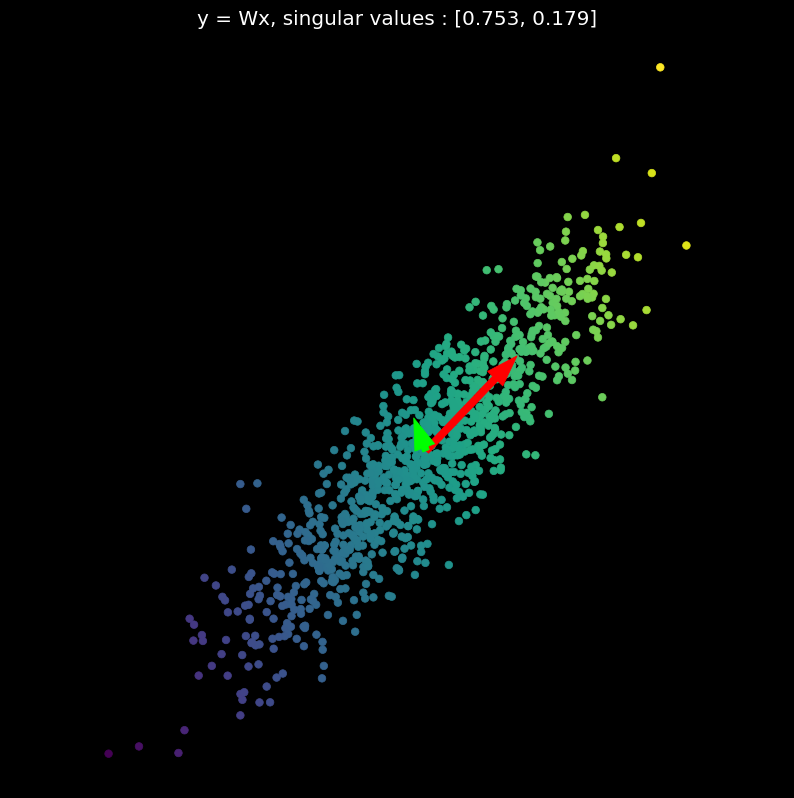

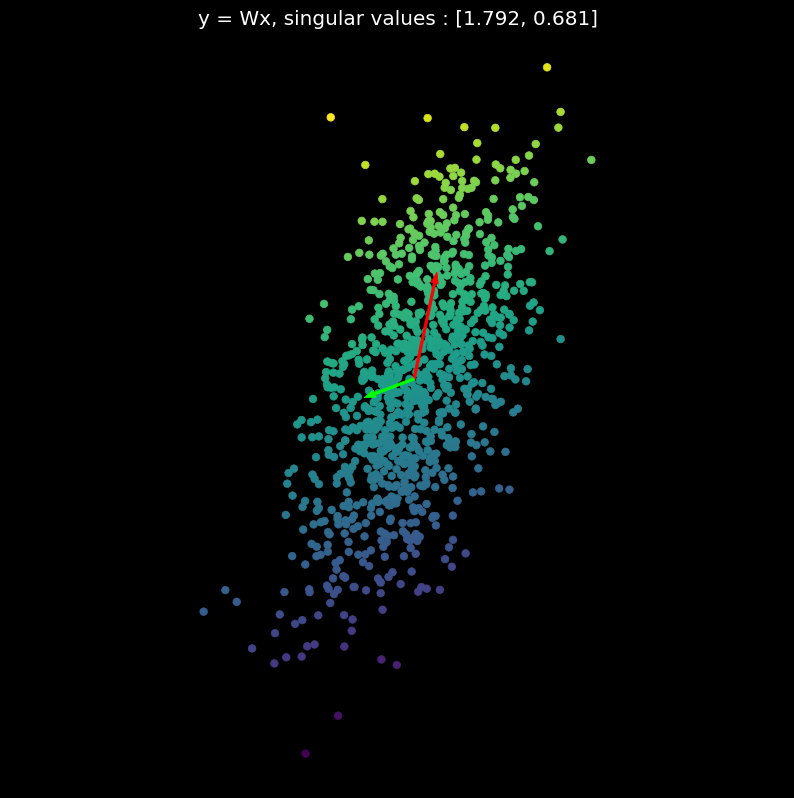

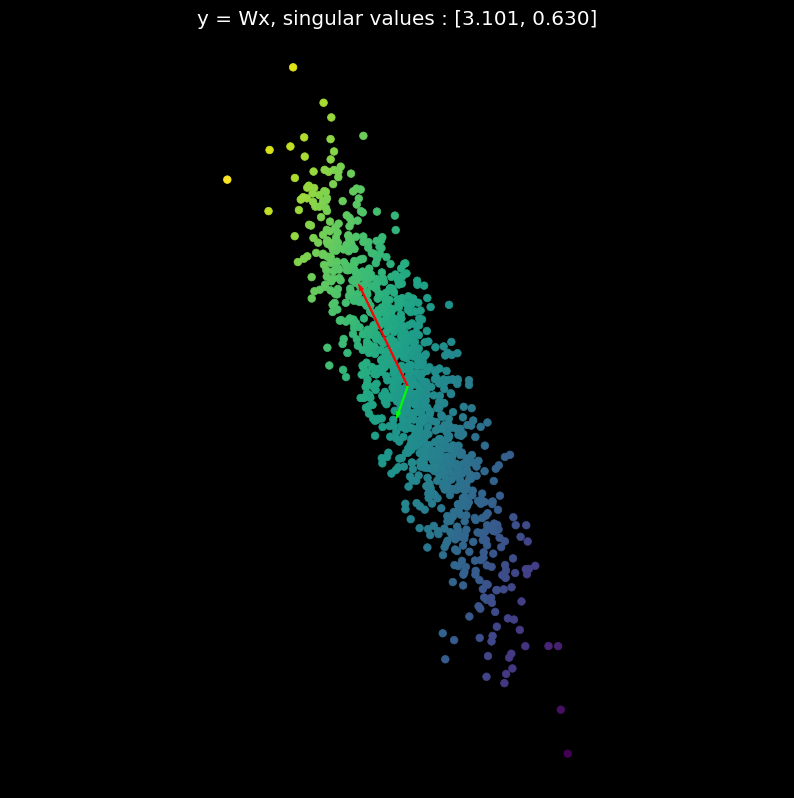

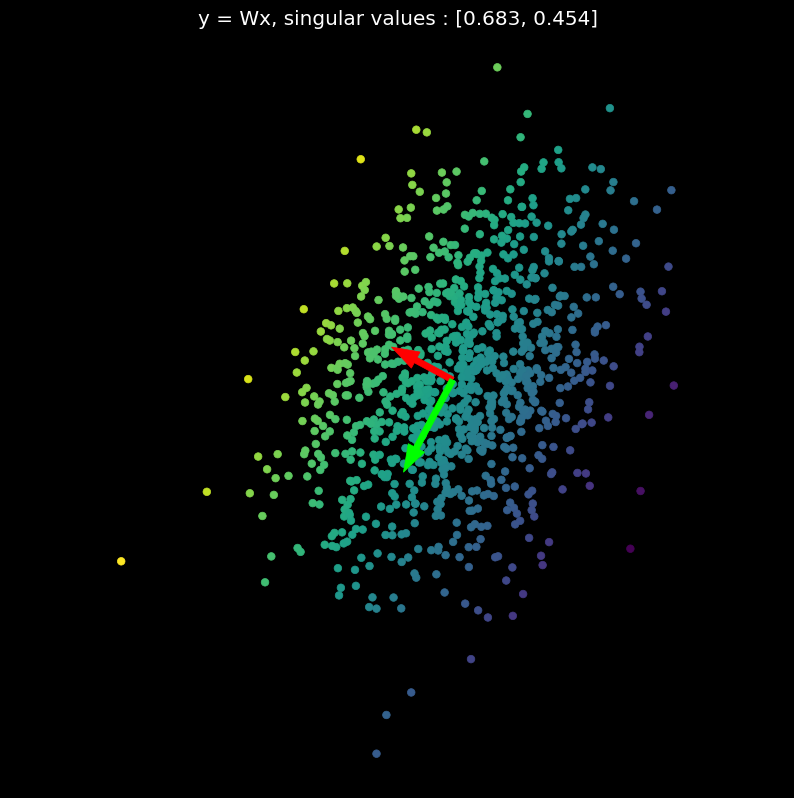

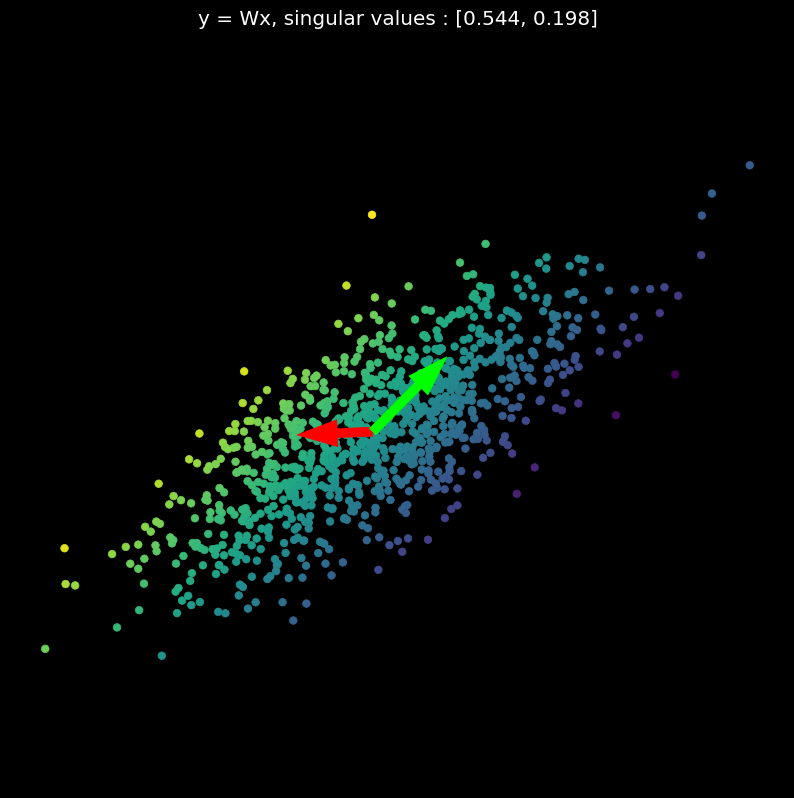

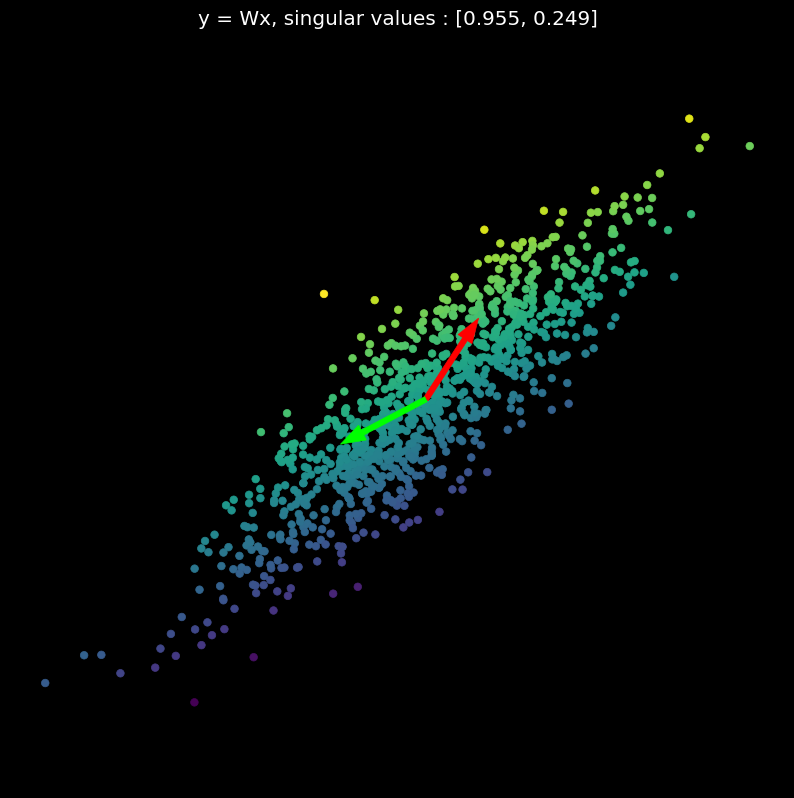

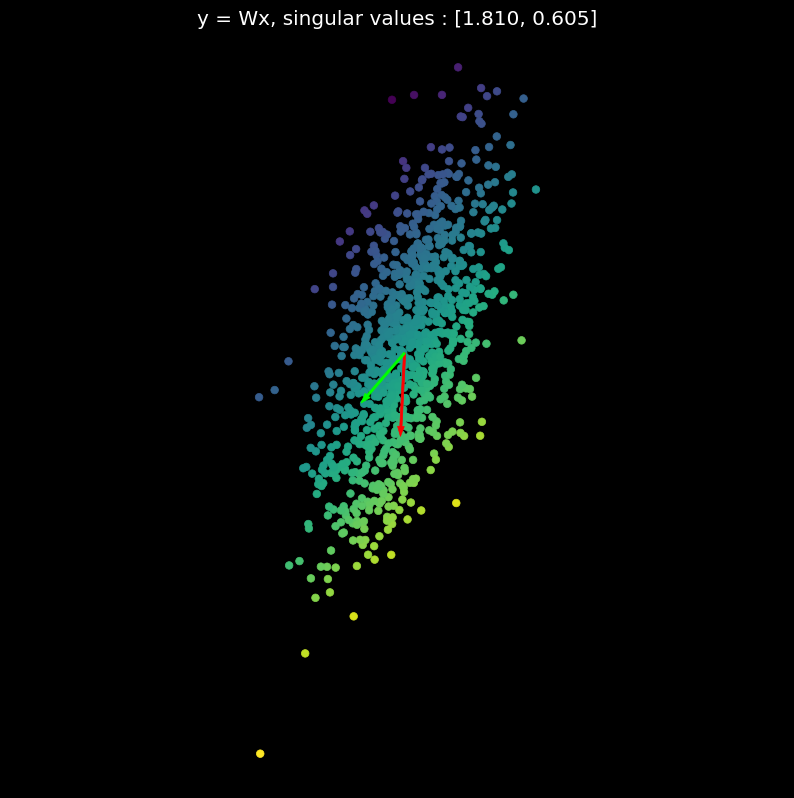

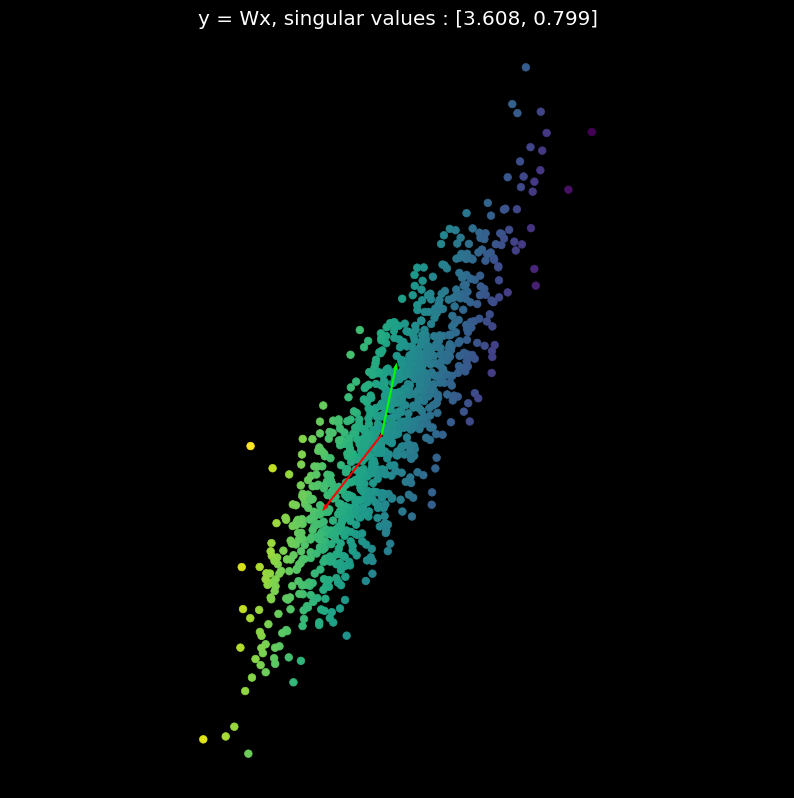

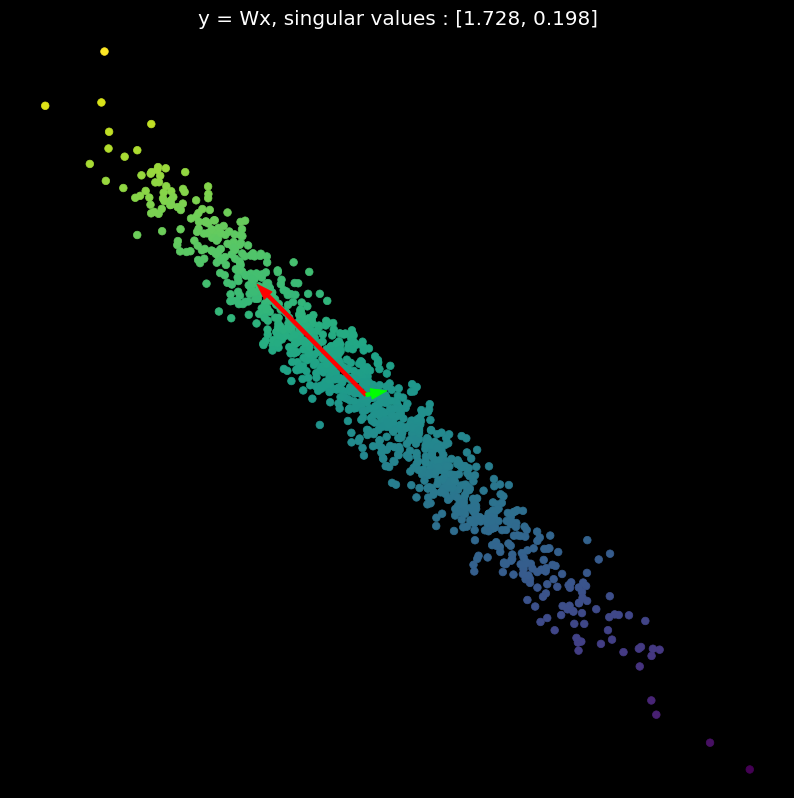

In [11]:
show_scatterplot(X, colors, title='X')
plot_bases(OI)

for i in range(10):
    # create a random matrix
    W = torch.randn(2, 2).to(device)
    # transform points
    Y = X @ W.t()
    # compute singular values
    U, S, V = torch.svd(W)
    # plot transformed points
    show_scatterplot(Y, colors, title='y = Wx, singular values : [{:.3f}, {:.3f}]'.format(S[0], S[1]))
    # transform the basis
    new_OI = OI @ W.t()
    # plot old and new basis
    #plot_bases(OI)
    plot_bases(new_OI)

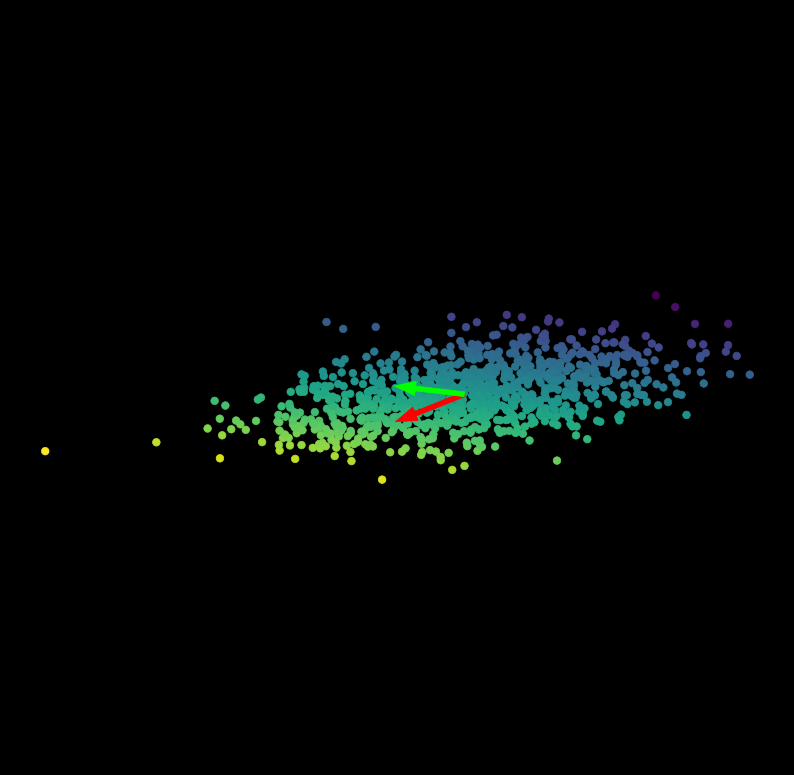

In [12]:
model = nn.Sequential(
        nn.Linear(2, 2, bias=False)
)
model.to(device)
with torch.no_grad():
    Y = model(X)
    show_scatterplot(Y, colors)
    plot_bases(model(OI))


Non-linear Transform: Map Points to a Square¶
Linear transforms can rotate, reflect, stretch and compress, but cannot curve
We need non-linearities for this
Can (approximately) map points to a square by first stretching out by a factor $s$, then squashing with a tanh function
$
   f(x)= \tanh \left(
  \left[ {\begin{array}{cc}
   s &amp; 0 \\
   0 &amp; s \\
  \end{array} } \right]  
  x
  \right)
$

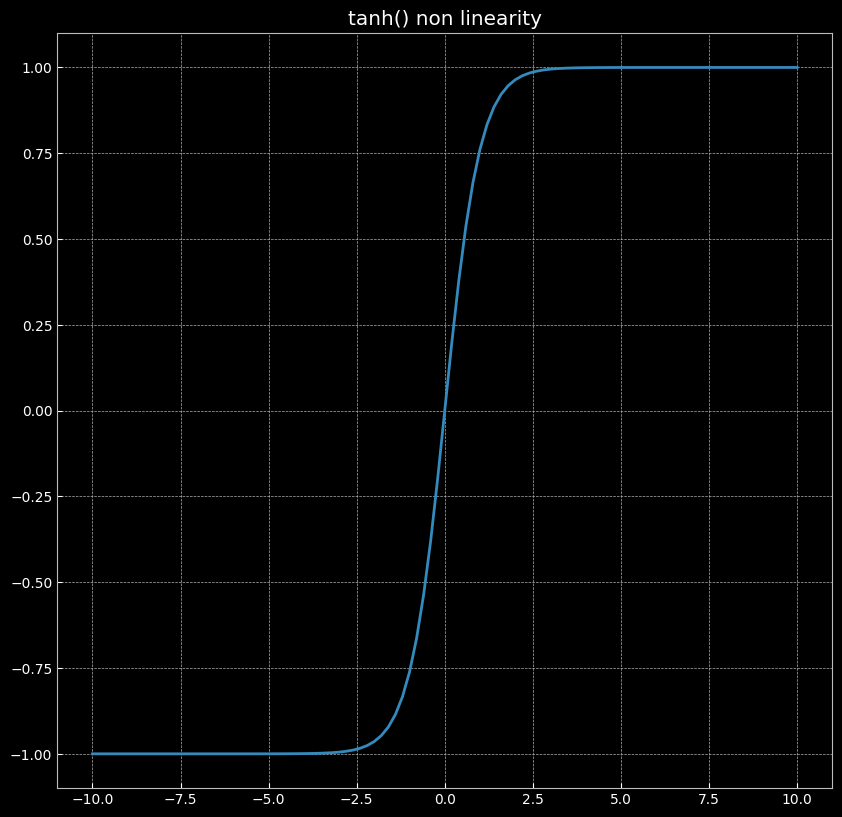

In [13]:
z = torch.linspace(-10, 10, 101)
s = torch.tanh(z)
plot(z.numpy(), s.numpy())
title('tanh() non linearity');

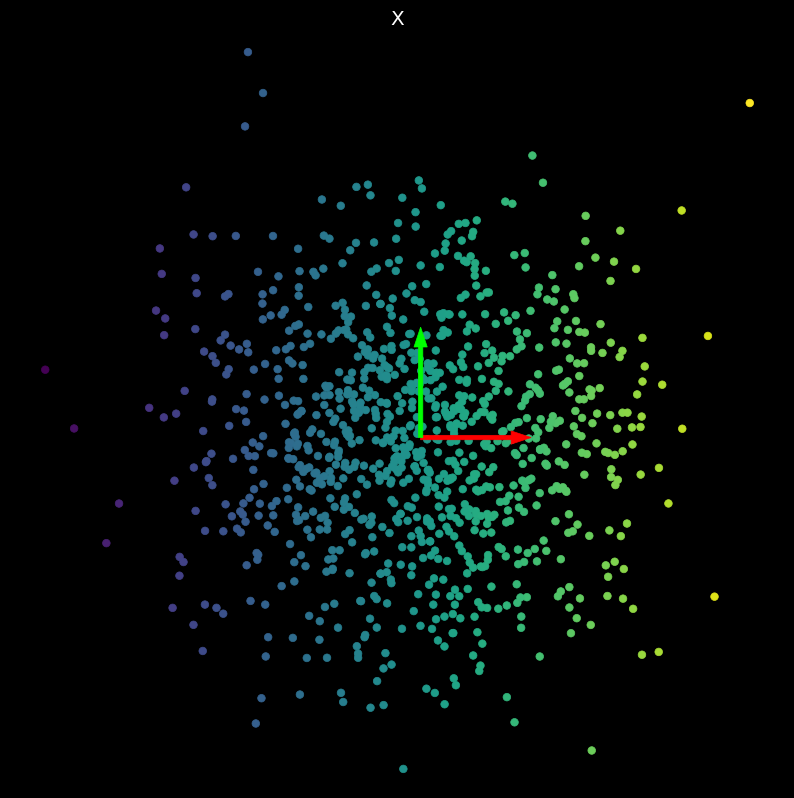

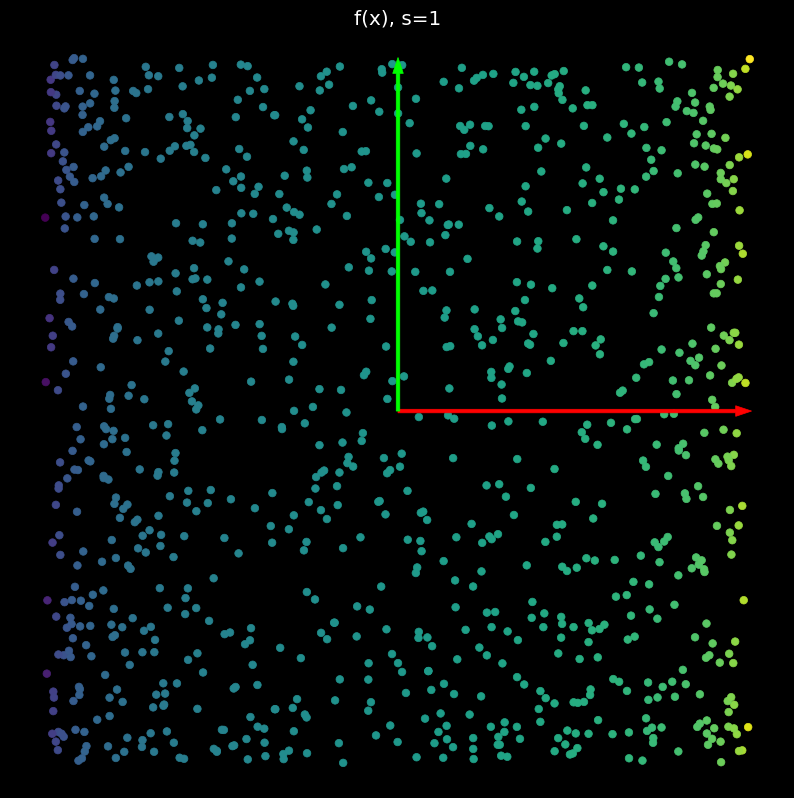

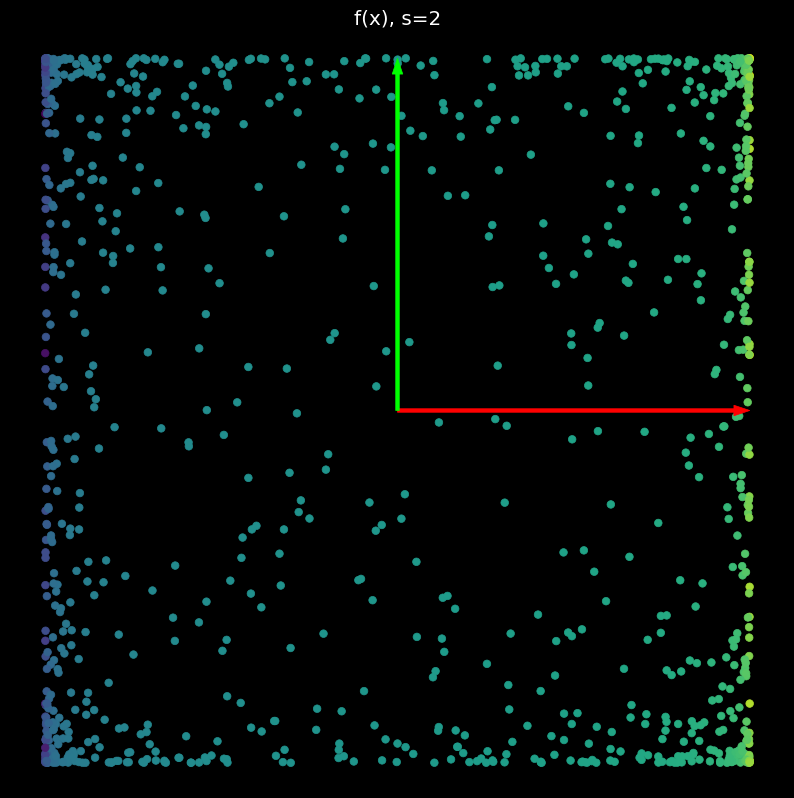

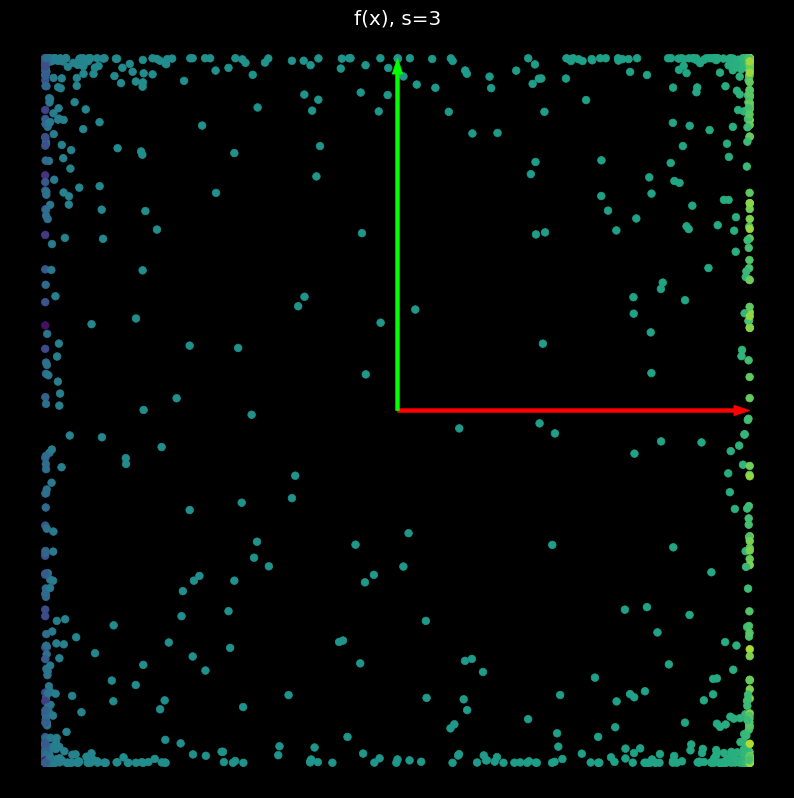

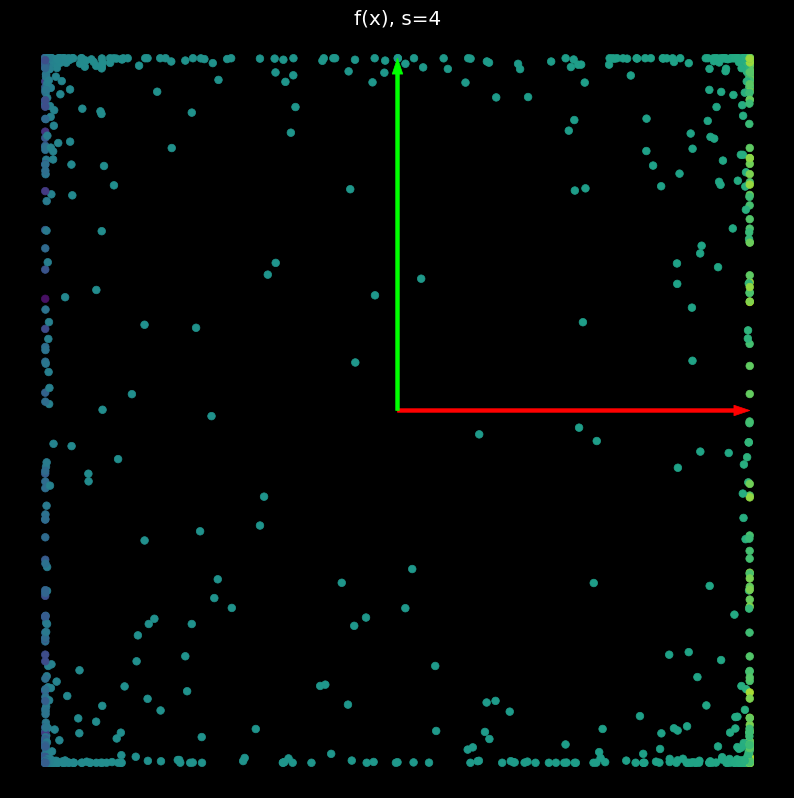

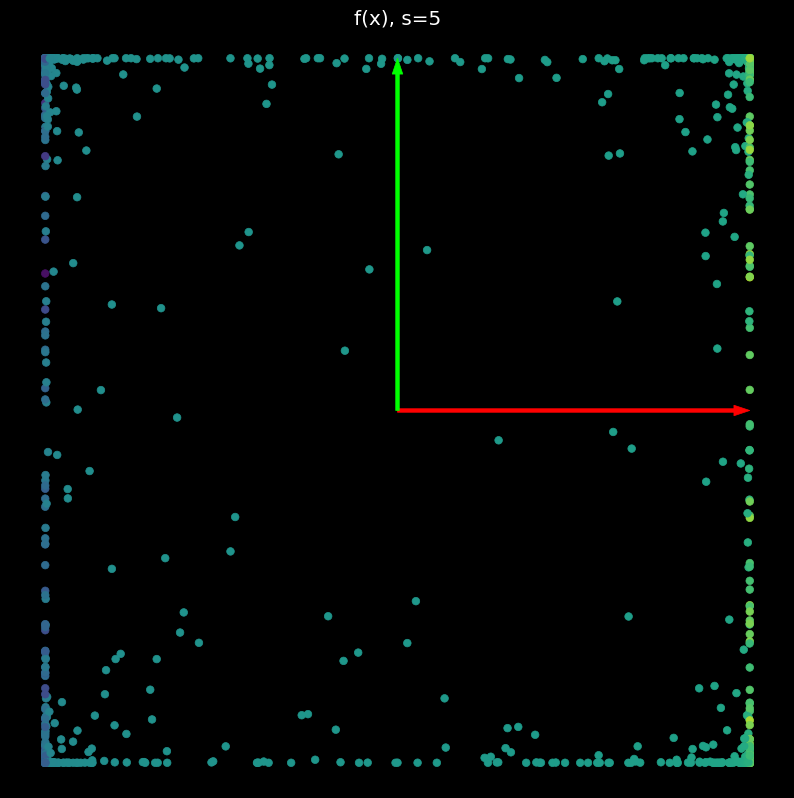

In [15]:
show_scatterplot(X, colors, title='X')
plot_bases(OI)

model = nn.Sequential(
        nn.Linear(2, 2, bias=False),
        nn.Tanh()
)

model.to(device)

for s in range(1, 6):
    W = s * torch.eye(2)
    model[0].weight.data.copy_(W)
    Y = model(X).data
    show_scatterplot(Y, colors, title=f'f(x), s={s}')
    plot_bases(OI, width=0.01)


Visualize Functions Represented by Random Neural Networks

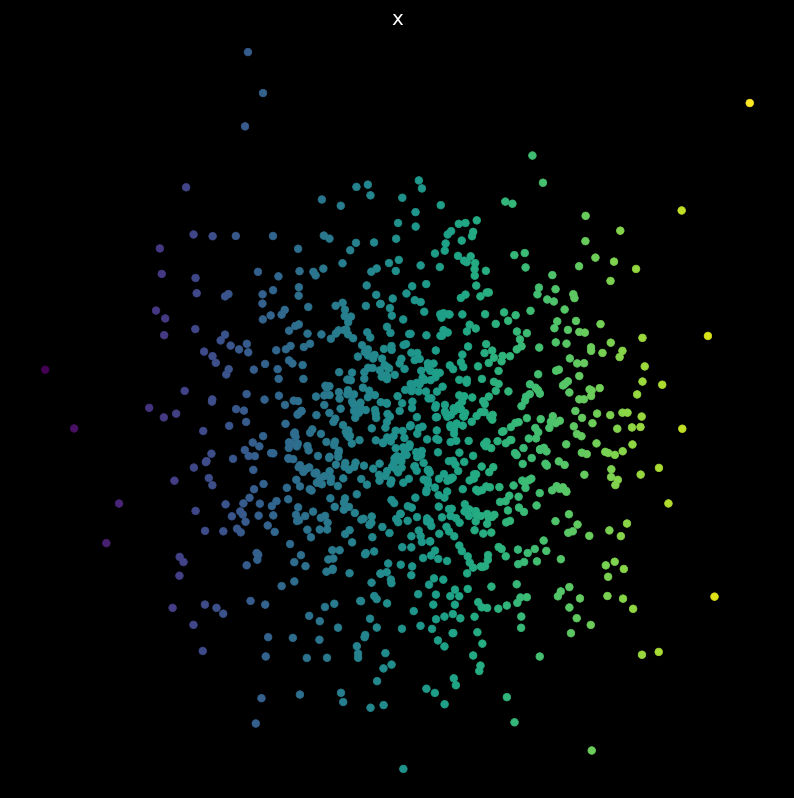

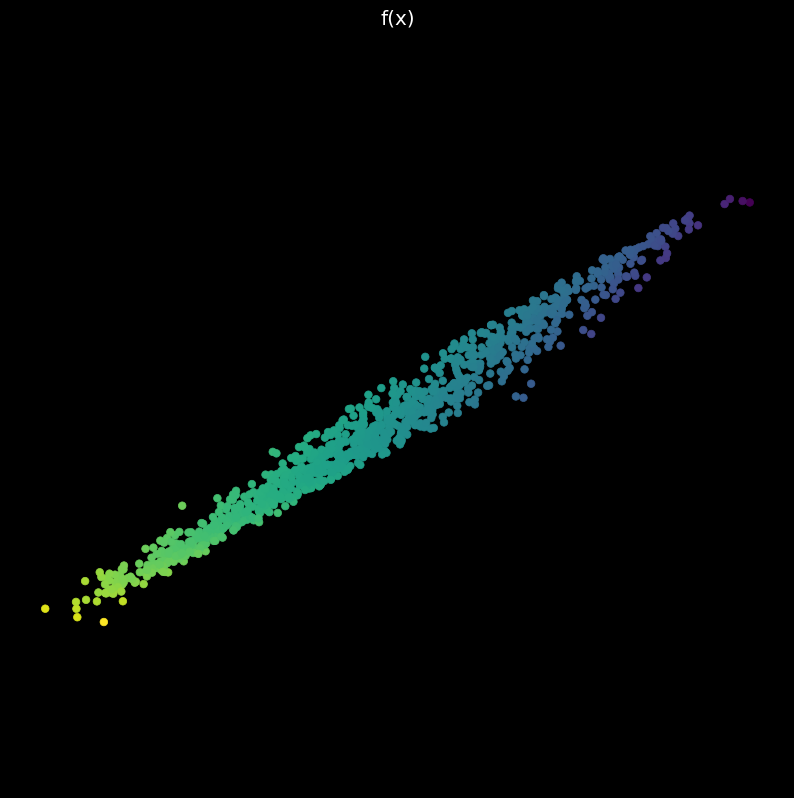

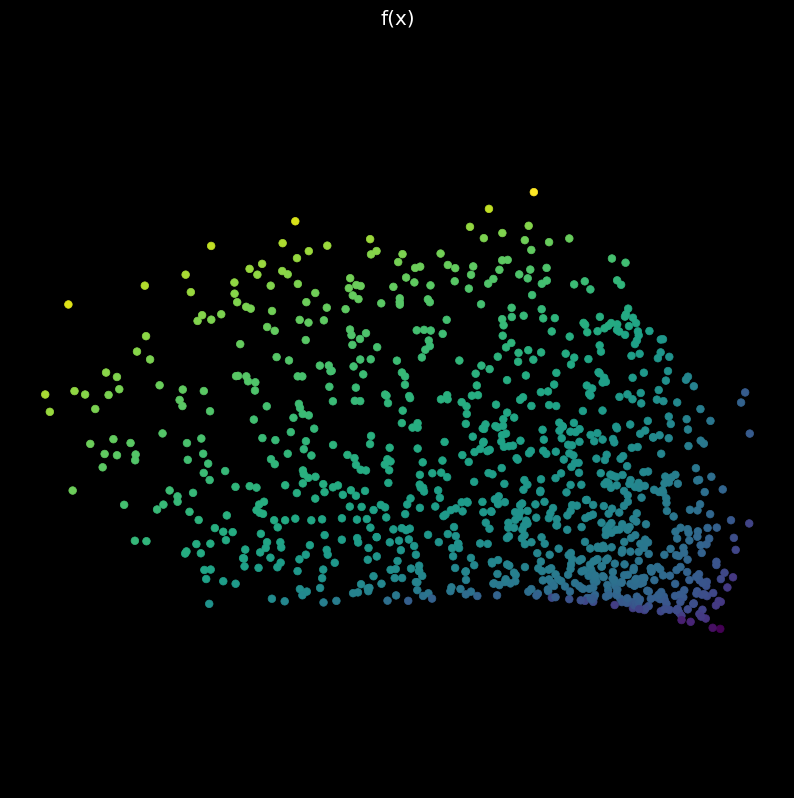

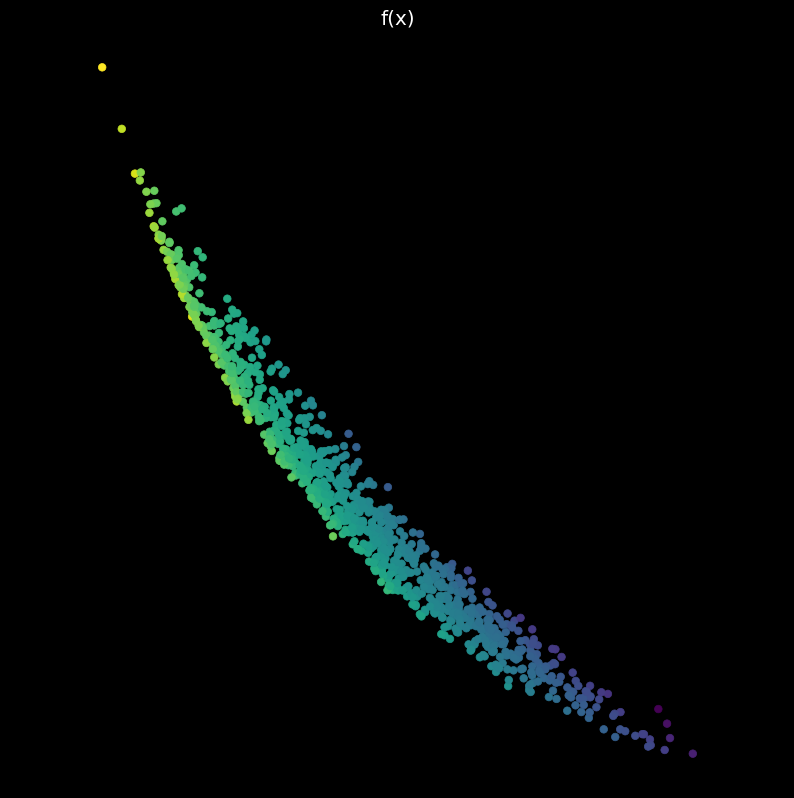

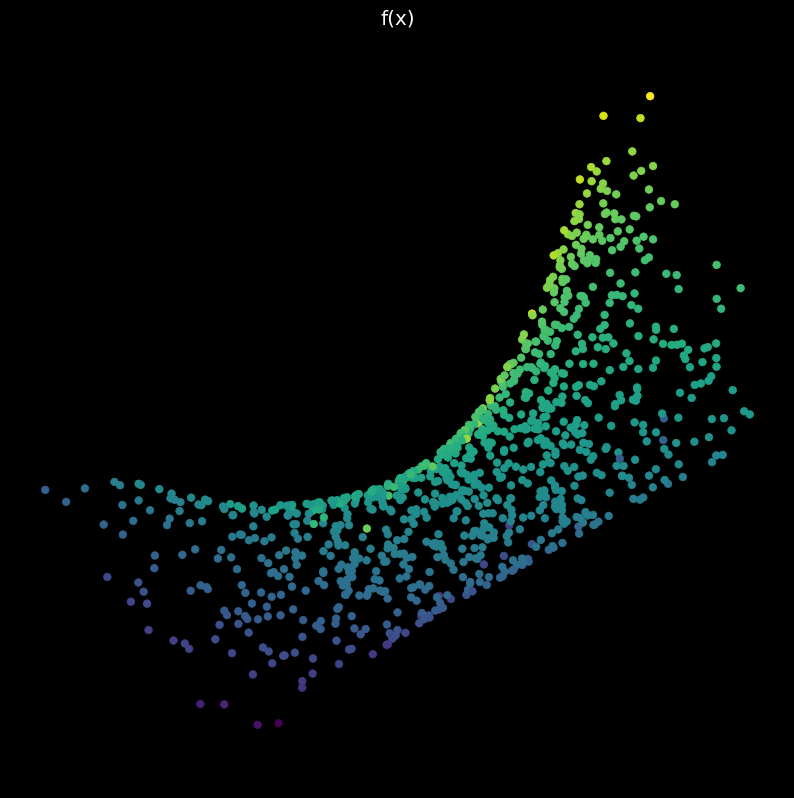

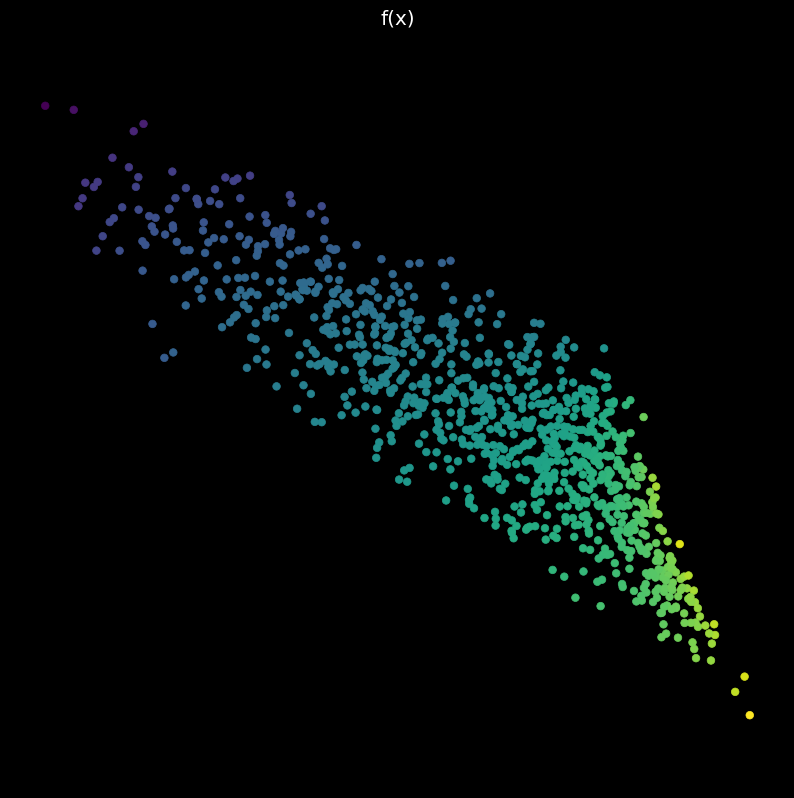

In [16]:
show_scatterplot(X, colors, title='x')
n_hidden = 5

# NL = nn.ReLU()
NL = nn.Tanh()

for i in range(5):
    # create 1-layer neural networks with random weights
    model = nn.Sequential(
            nn.Linear(2, n_hidden), 
            NL, 
            nn.Linear(n_hidden, 2)
        )
    model.to(device)
    with torch.no_grad():
        Y = model(X)
    show_scatterplot(Y, colors, title='f(x)')
#     plot_bases(OI)

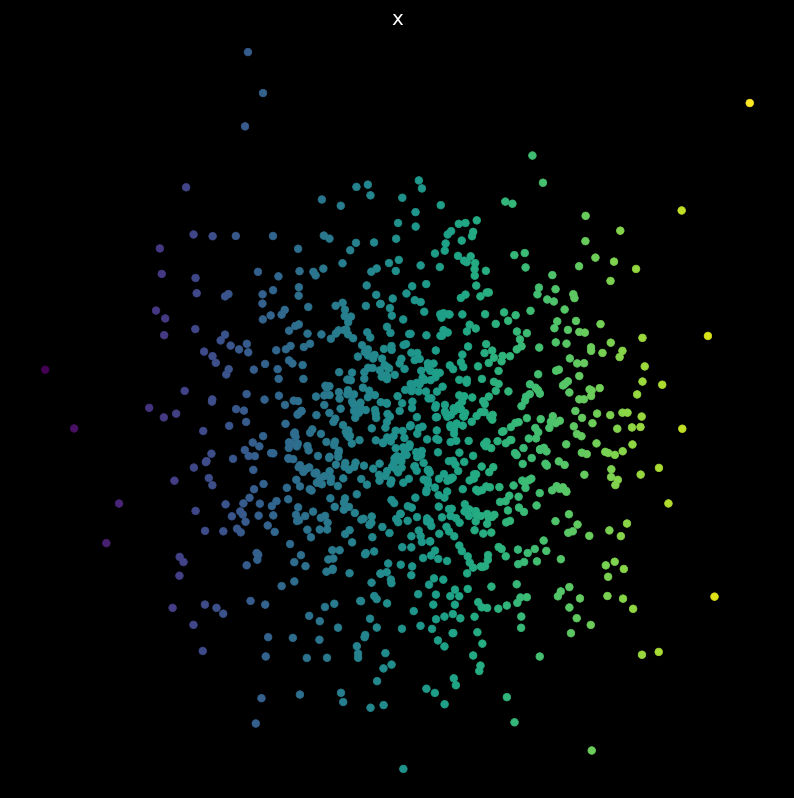

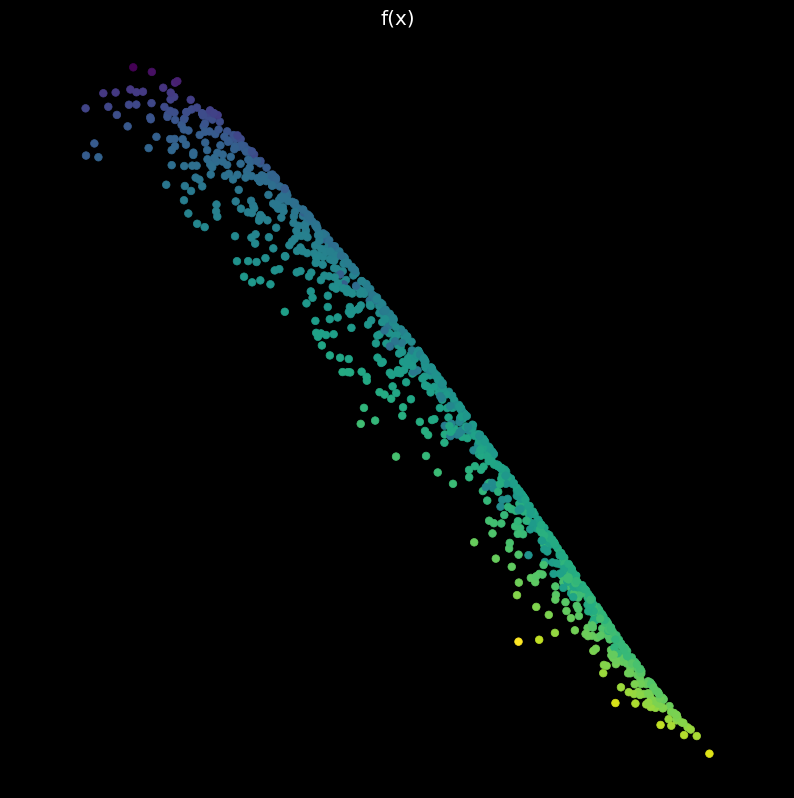

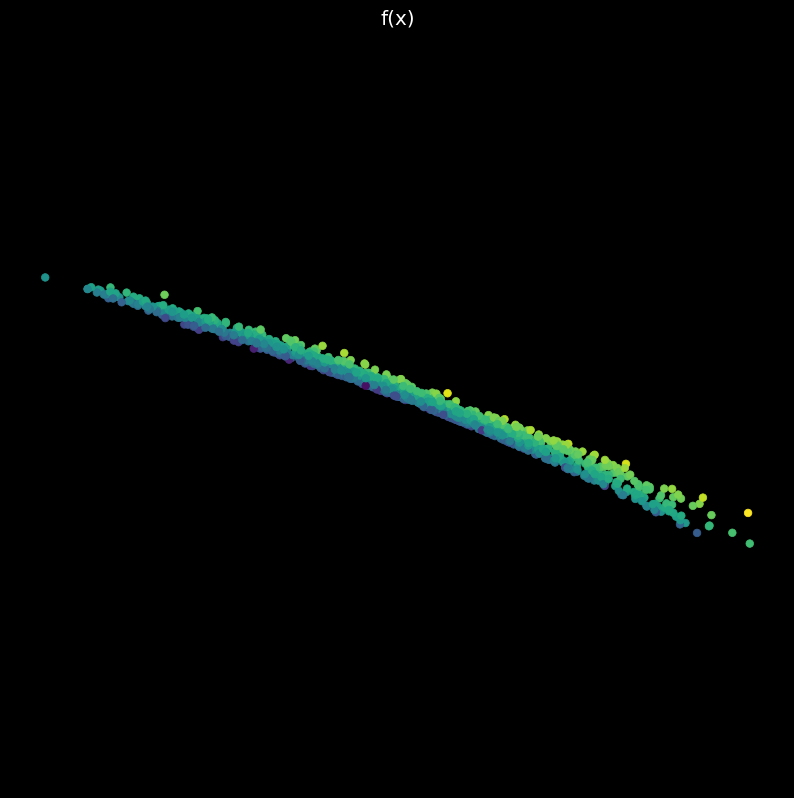

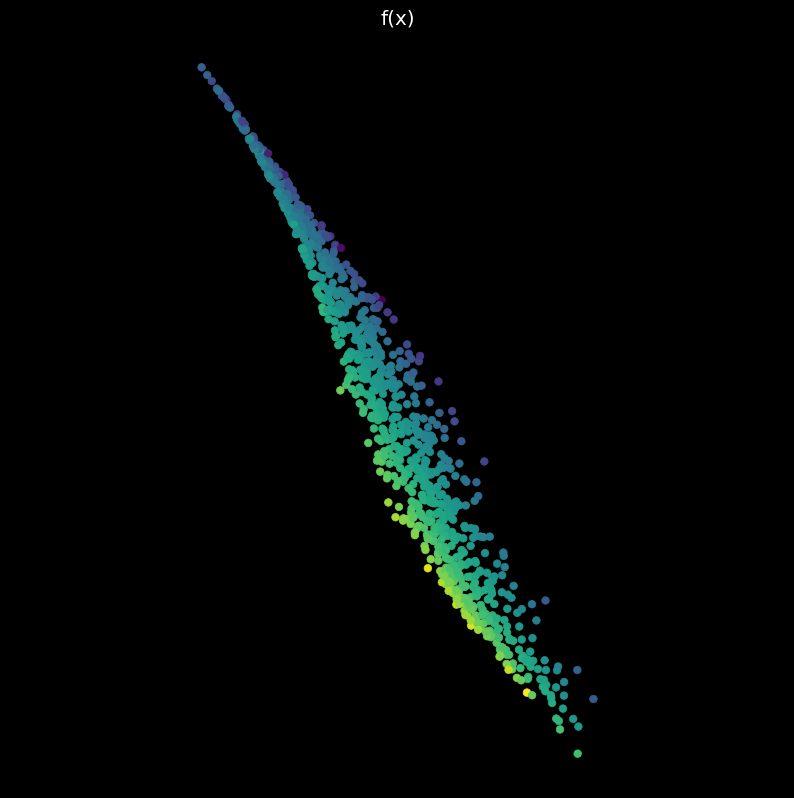

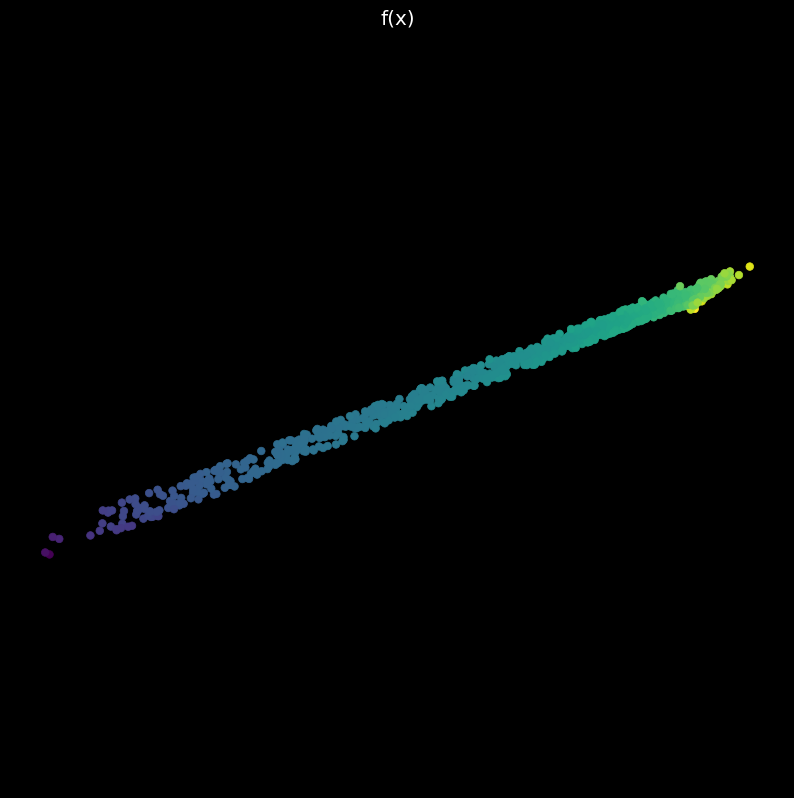

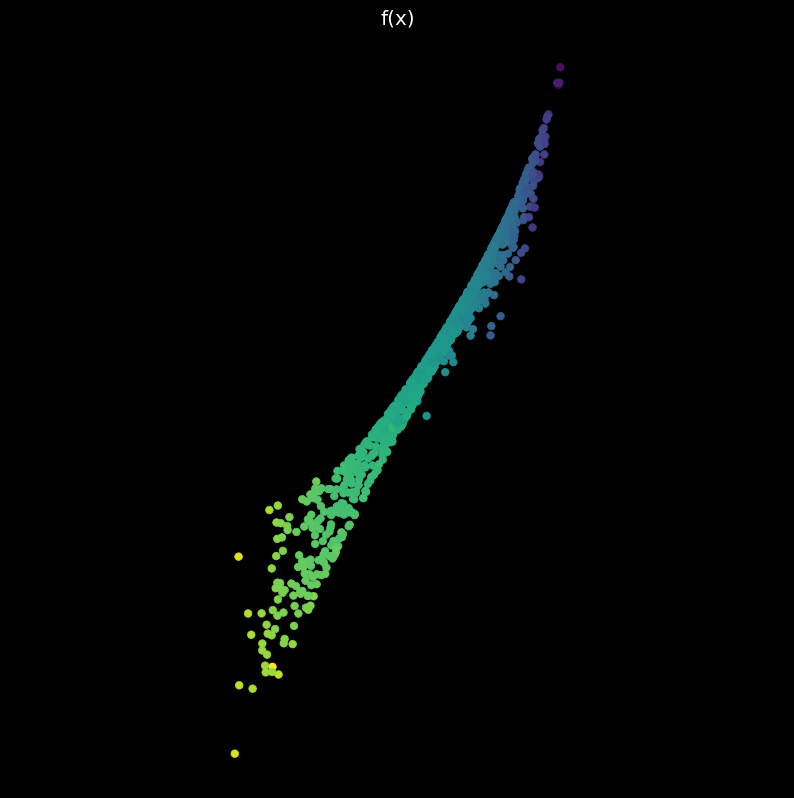

In [17]:

# deeper network with random weights
show_scatterplot(X, colors, title='x')
n_hidden = 5

# NL = nn.ReLU()
NL = nn.Tanh()

for i in range(5):
    model = nn.Sequential(
        nn.Linear(2, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, 2)
    )
    model.to(device)
    with torch.no_grad():
        Y = model(X).detach()
    show_scatterplot(Y, colors, title='f(x)')

# Netwoek

In [18]:
import torch
from torch import nn
image = torch.randn(3, 10, 20)
d0 = image.nelement()

class mynet(nn.Module):
    def __init__(self, d0, d1, d2, d3):
        super().__init__()
        self.m0 = nn.Linear(d0, d1)
        self.m1 = nn.Linear(d1, d2)
        self.m2 = nn.Linear(d2, d3)

    def forward(self,x):
        z0 = x.view(-1)  # flatten input tensor
        s1 = self.m0(z0)
        z1 = torch.relu(s1)
        s2 = self.m1(z1)
        z2 = torch.relu(s2)
        s3 = self.m2(z2)
        return s3
model = mynet(d0, 60, 40, 10)
out = model(image)

In [30]:
out.shape

torch.Size([10])

# ANN

In [40]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [33]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

In [36]:
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


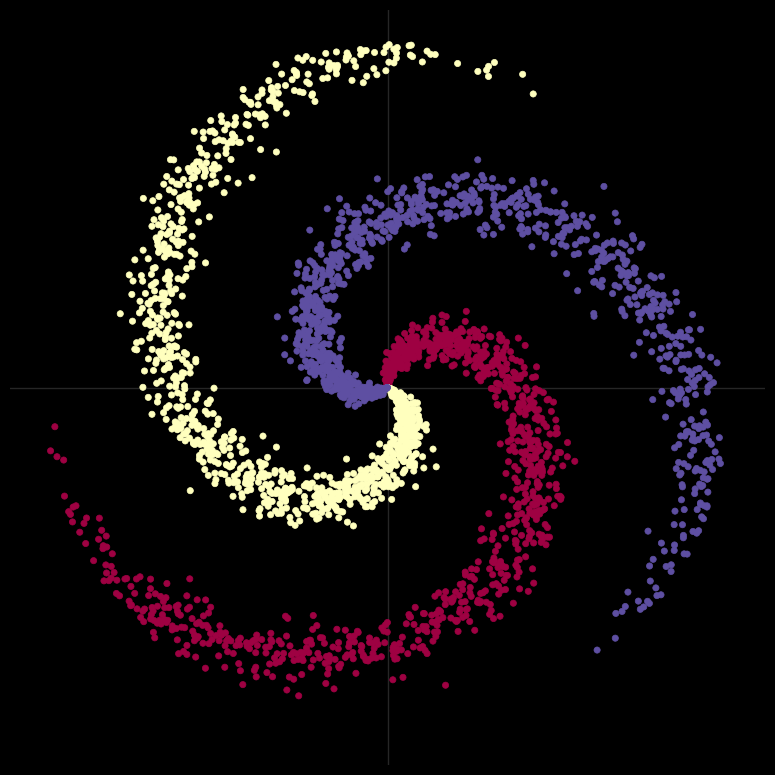

In [37]:
# visualise the data
plot_data(X, y)

In [38]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [41]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) #Convert to CUDA

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.873481, [ACCURACY]: 0.509


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=3, bias=True)
)


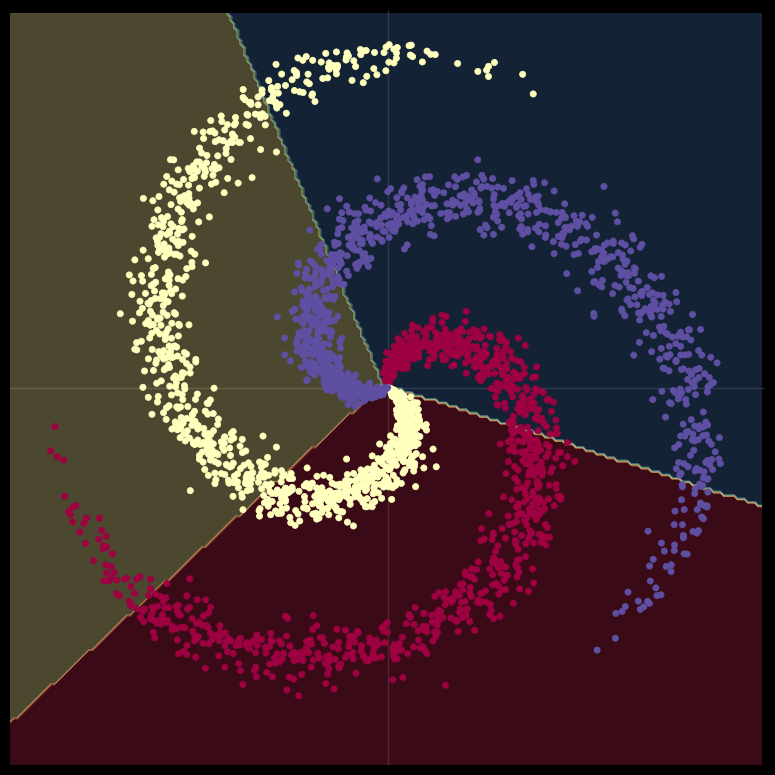

In [42]:
# Plot trained model
print(model)
plot_model(X, y, model)

In [43]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [44]:
# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.170587, [ACCURACY]: 0.953


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


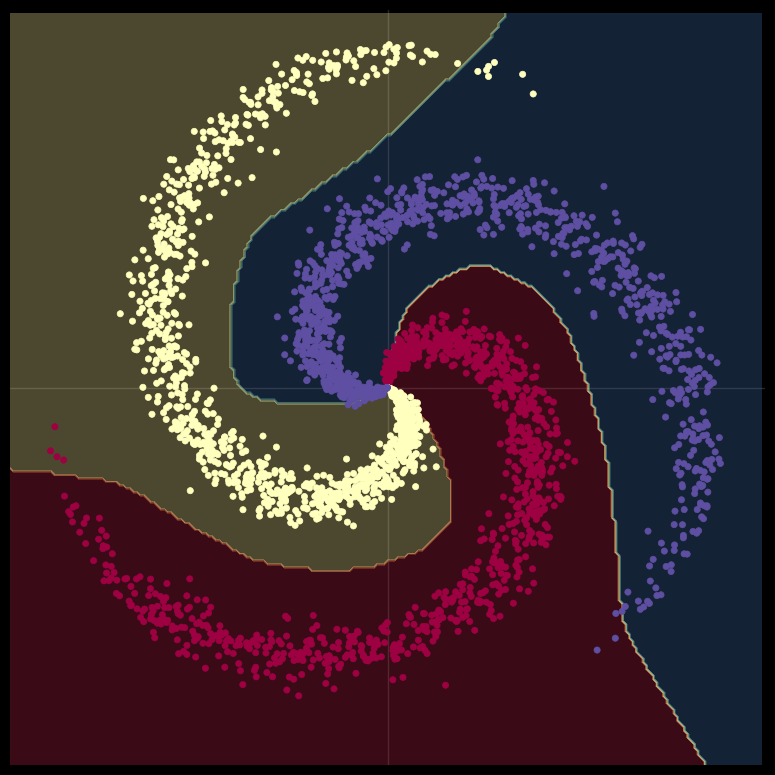

In [45]:
# Plot trained model
print(model)
plot_model(X, y, model)

# CNN

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


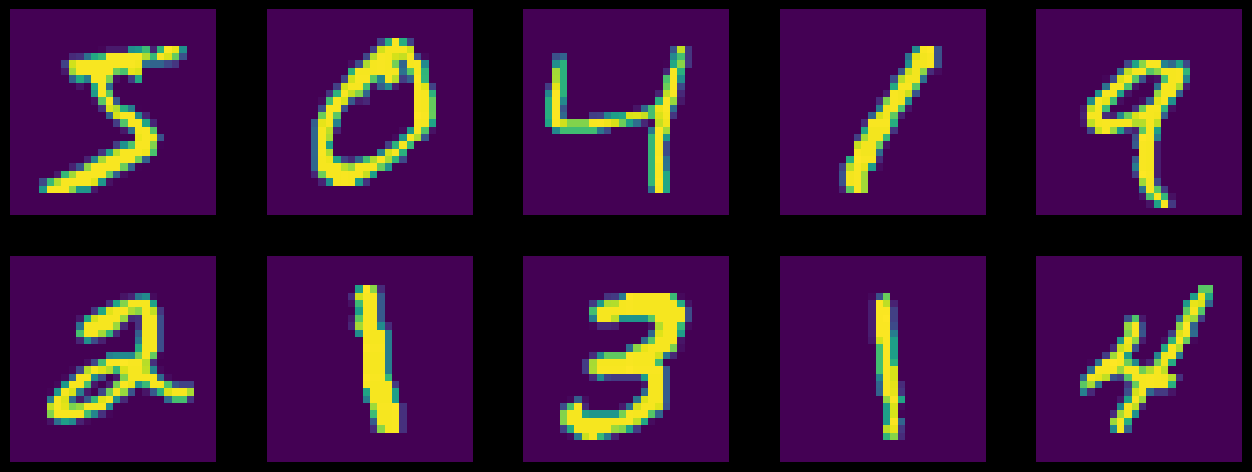

In [59]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [60]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [61]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [63]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.333165
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.793630
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.227438
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.979954
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.806351
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.676532
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.547909
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.385242
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.431818
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.408043

Test set: Average loss: 0.4176, Accuracy: 8800/10000 (88%)



In [64]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299664


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.979007
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.435456
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.332588
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.279286
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.304627
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.354419
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.301667
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.157992
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.270790

Test set: Average loss: 0.1808, Accuracy: 9445/10000 (94%)



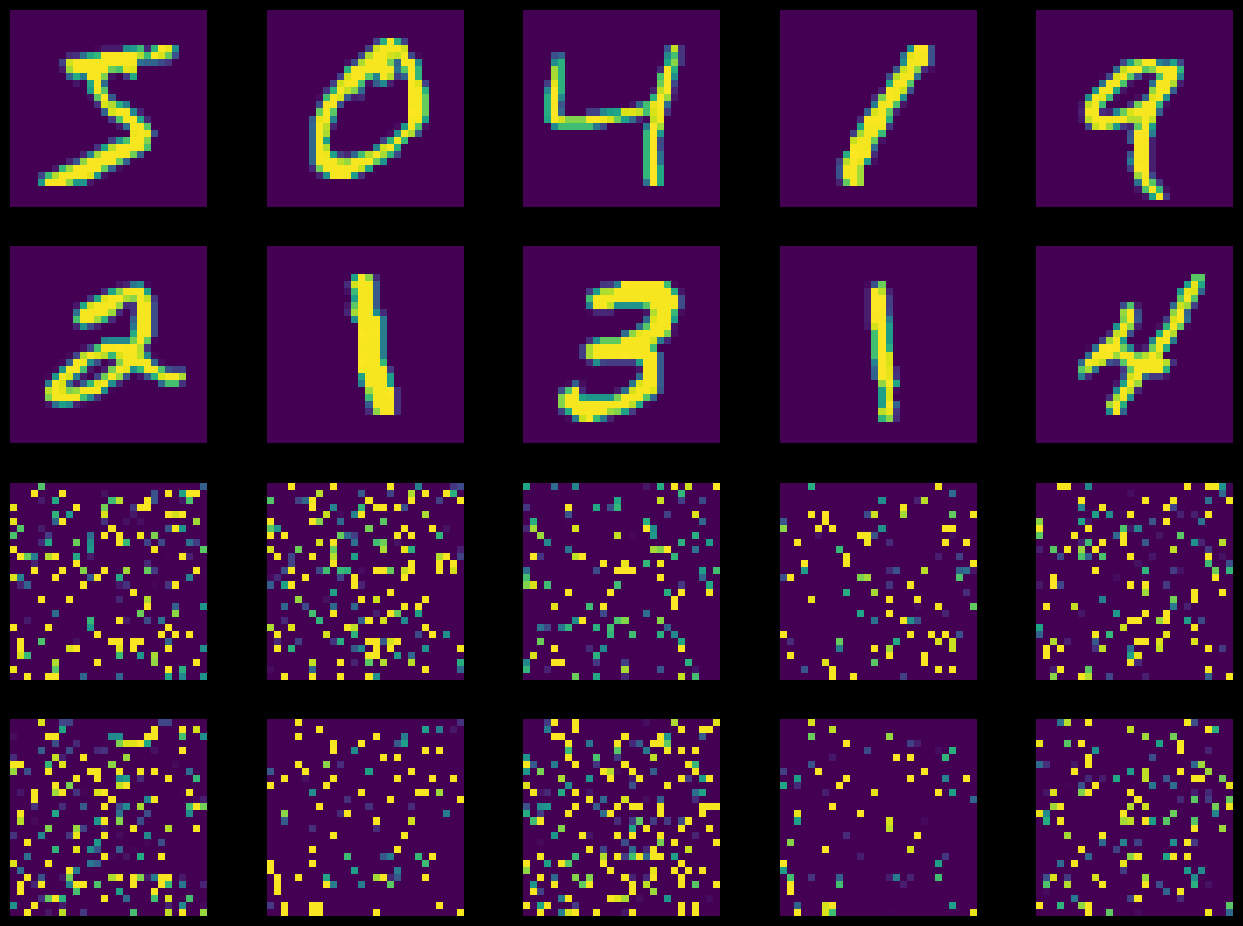

In [65]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

In [66]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.330687
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.278553
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.250298
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.096896
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.821845
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.609075
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.968262
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.027494
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.744666
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.493596

Test set: Average loss: 0.6304, Accuracy: 8097/10000 (81%)



In [67]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.291373
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.500585
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.931193
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.604634
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.447529
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.465632
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.441764
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.417092
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.497246
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.416204

Test set: Average loss: 0.3974, Accuracy: 8850/10000 (88%)

